In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Parameter windowing
input_width = 60*2
label_width = 60
shift = label_width
total_window_size = input_width + shift
OUT_STEPS = label_width
# Definisikan irisan untuk input dan label
input_slice = slice(0, input_width)
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
train_df = None
output_selected=['RRU.PrbUsedDl']
train_name_cells=['S1/B2/C1']
test_name_cells=['S7/B2/C1']

In [2]:
def  import_data(file_path="D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv"):
    
    df_1=pd.read_csv(file_path)
    convert_time=pd.to_datetime(df_1['timestamp'], unit='ms',origin='unix')
    df_1.insert(df_1.columns.get_loc('timestamp') + 1, 'datetime_column', convert_time)
    df_1.insert(df_1.columns.get_loc('datetime_column') + 2, 'hour', df_1['datetime_column'].dt.hour+df_1['datetime_column'].dt.minute/60)
    df_1.set_index('datetime_column', inplace=True)
    df_1.drop(columns=['timestamp'], inplace=True)
    df_1['sin_time'] = np.sin(df_1['hour'] * (2 * np.pi / 24))
    df_1['cos_time'] = np.cos(df_1['hour']* (2 * np.pi / 24))
    seleted_columns = ['Viavi.Cell.Name','RRU.PrbUsedDl', 'sin_time', 'cos_time'] 
    df_2= df_1[seleted_columns].copy()
    cell_name= train_name_cells+ test_name_cells
    df= df_2[df_2['Viavi.Cell.Name'].isin(cell_name)].copy()
    
    return df, cell_name

In [3]:
def standardize_data(data, train_df, isoutput=True, column_output=output_selected):
    if isoutput:
        median = train_df[column_output].median().values
        q1 = train_df[column_output].quantile(0.25).values
        q3 = train_df[column_output].quantile(0.75).values
    else:
        median = train_df.median().values
        q1 = train_df.quantile(0.25).values
        q3 = train_df.quantile(0.75).values

    iqr = q3 - q1

    # Reshape for broadcasting with 2D matrix
    median = median.reshape(1, -1)
    iqr = iqr.reshape(1, -1)

    return (data - median) / iqr

def inverse_standardize_data(data, train_df, isoutput=True, column_output=output_selected):
    if isoutput:
        median = train_df[column_output].median().values
        q1 = train_df[column_output].quantile(0.25).values
        q3 = train_df[column_output].quantile(0.75).values
    else:
        median = train_df.median().values
        q1 = train_df.quantile(0.25).values
        q3 = train_df.quantile(0.75).values

    iqr = q3 - q1

    # Reshape for broadcasting with 2D matrix
    median = median.reshape(1, -1)
    iqr = iqr.reshape(1, -1)

    return data * iqr + median

In [4]:
def make_windows(data_x,data_y, total_window_size, input_slice, labels_slice):
    x = []
    y = []
    for i in range(len(data_x) - total_window_size + 1):
        window_x = data_x[i:i+total_window_size]
        x.append(window_x[input_slice])

    for i in range(len(data_y) - total_window_size + 1):
        window_y= data_y[i:i+total_window_size]
        y.append(window_y[labels_slice])

    return np.array(x), np.array(y)


In [5]:
def compute_metrics(actual_df, predictions_df):
    mae = mean_absolute_error(actual_df, predictions_df)
    mse = mean_squared_error(actual_df, predictions_df)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_df - predictions_df) / actual_df)) * 100
    return mae, mape, mse, rmse

def process_predictions(model, x_scaled, actual_df, input_width, label_width, columns):
    predictions = model.predict(x_scaled[slice(None, None, label_width), :, :])
    predictions_reshaped = predictions.reshape(-1, len(columns))
    predictions_unscaled = inverse_standardize_data(predictions_reshaped, isoutput=True, train_df=train_df)
    predictions_df = pd.DataFrame(predictions_unscaled, columns=columns, index=actual_df[input_width:].index)
    return predictions_df
def compute_error( x_scaled, actual_df, columns, model):
    
    # Process predictions for training and validation sets
    predictions_df = process_predictions(model, x_scaled, actual_df, input_width, label_width, columns)

    df_predact= pd.concat((predictions_df.rename(columns={columns[0]: '%spredict'%columns[0]}), actual_df[input_width:]), axis=1)
    
    display(df_predact)
    mae, mape, mse, rmse = compute_metrics(actual_df[input_width:], predictions_df)
    
    print(f"MAE: {mae}, MAPE %: {mape}, MSE: {mse}, RMSE: {rmse}")
    return df_predact

In [6]:

def plot_predictions(val_df, x_val_scaled, model, val_scaled, input_width, label_width, num_features):
    num_output = 1


    # Predictions for validation data
    val_predictions = model.predict(x_val_scaled[slice(None,None,label_width), :, :])
    predictions_reshaped = val_predictions.reshape(-1, num_output)
    predictions_unscaled = inverse_standardize_data(predictions_reshaped, isoutput=True, train_df=train_df)
    val_predictions_df = pd.DataFrame(predictions_unscaled, columns=output_selected, index=val_df.index)

    # Generate new predictions
    val_new = val_scaled.tail(input_width).to_numpy()
    val_new = val_new.reshape(1, -1, num_features)
    generate_predictions = model.predict(val_new)
    generate_predictions = inverse_standardize_data(generate_predictions.reshape(-1, num_output), isoutput=True, train_df=train_df)
    generate_predictions_df = pd.DataFrame(generate_predictions, columns=output_selected, index=val_df.tail(label_width).index + pd.DateOffset(hours=1))

    # Combine predictions
    all_predictions = pd.concat([val_predictions_df, generate_predictions_df], axis=0)
    inputs_graph = val_df[output_selected].iloc[-label_width * 3:-label_width]
    labels_graph = val_df[output_selected].iloc[-label_width:]
    predictions_graph = all_predictions.loc[labels_graph.index]
    new_predictions_graph = all_predictions.loc[generate_predictions_df.index]

    # Plotting
    plt.figure(figsize=(16, 8))
    for n, feature in enumerate(all_predictions.columns):
        plt.subplot(len(all_predictions.columns), 1, n + 1)
        plt.plot(inputs_graph.index, inputs_graph[feature], label='Inputs for orange', marker='.', zorder=-100, markersize=5)
        plt.plot(labels_graph.index, labels_graph[feature], label='actual output for orange and inputs for red', marker='.', zorder=-100, c='#2ca02c')
        plt.scatter(predictions_graph.index, predictions_graph[feature], marker='X', edgecolors='k', label='Prediction', c='#ff7f0e', s=int(32 * 1.5))
        plt.scatter(new_predictions_graph.index, new_predictions_graph[feature], marker='+', label='New prediction', c='#FF012D', s=int(32 * 1.5))
        plt.ylabel(feature)
        plt.legend()

    plt.subplots_adjust(hspace=0.2, top=1)
    plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import time

def tensorflow_cnn(X_train_scaled, Y_train_scaled, X_validation_scaled, Y_validation_scaled, 
                    learning_rate, target_error, max_epochs, max_sampel_batch,
                    patience, save_best_model_path, validation_data=False, load_model=None, out_steps=OUT_STEPS):
    global model

    class MAEStopCallback(tf.keras.callbacks.Callback):
        def __init__(self, threshold):
            super(MAEStopCallback, self).__init__()
            self.threshold = threshold

        def on_epoch_end(self, epoch, logs=None):
            if logs['mae'] < self.threshold:
                print(f"\nMAE reached below {self.threshold}. Stopping training.")
                self.model.stop_training = True

                
    input_width = X_train_scaled.shape[1]
    CONV_WIDTH = input_width # Define the width of the convolutional window
    num_features = X_train_scaled.shape[2]
    num_output = Y_train_scaled.shape[2]
    out_steps = out_steps

    model = tf.keras.models.Sequential()
    if load_model is None:
        model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :], input_shape=(input_width, num_features)))
        model.add(tf.keras.layers.Conv1D(120, activation='relu', kernel_size=int(CONV_WIDTH/8), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv1D(120, activation='relu', kernel_size=int(CONV_WIDTH/4),padding='same') )
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv1D(120, activation='relu', kernel_size=int(CONV_WIDTH),padding='valid') )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(out_steps * num_output, kernel_initializer=tf.initializers.zeros()))
        model.add(tf.keras.layers.Reshape([out_steps, num_output]))

    else:
        print("Load model")
        model = tf.keras.models.load_model(load_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    mae_stop_callback = MAEStopCallback(threshold=target_error)
    checkpoint_callback = ModelCheckpoint(
        save_best_model_path,
        monitor='val_loss',     
        mode='min',         
        save_best_only=True, 
        verbose=1            
    )

    early_stopping_callback = EarlyStopping(
        monitor='loss',     
        mode='min',         
        patience=patience,    
        restore_best_weights=True,
        verbose=1            
    )

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=int(1), min_lr=0.00001, verbose=1)

    time_start = time.time()
    if validation_data:
        model.fit(X_train_scaled, Y_train_scaled, epochs=max_epochs, batch_size=max_sampel_batch,  
                  callbacks=[mae_stop_callback, checkpoint_callback, early_stopping_callback, reduce_lr], 
                  validation_data=(X_validation_scaled, Y_validation_scaled), validation_batch_size=max_sampel_batch)
    else:
        model.fit(X_train_scaled, Y_train_scaled, epochs=max_epochs, batch_size=max_sampel_batch, 
                  callbacks=[mae_stop_callback, checkpoint_callback, early_stopping_callback, reduce_lr])
    
    print("time computation seconds: ", time.time() - time_start)
    
    loss, MSE, MAE, RMSE, MAPE = model.evaluate(X_train_scaled, Y_train_scaled)
    print("loss: ", loss, "MSE: ", MSE, "MAE: ", MAE, "RMSE: ", RMSE, "MAPE: ", MAPE)
    
    return model, loss, MSE, MAE, RMSE, MAPE


In [8]:
def running_program(train_df,val_df, index_cell, name_file, name_file_before):
    
    train_scaled = standardize_data(train_df, isoutput=False, train_df=train_df)
    val_scaled= standardize_data(val_df, isoutput=False, train_df=train_df)
    # Membuat windowed dataset untuk set pelatihan, validasi, dan pengujian

    x_train_scaled, y_train_scaled = make_windows(train_scaled.to_numpy(), train_scaled[output_selected].to_numpy(),total_window_size, input_slice, labels_slice)
    x_val_scaled, y_val_scaled = make_windows(val_scaled.to_numpy(), val_scaled[output_selected].to_numpy(),total_window_size, input_slice, labels_slice)
    print(x_train_scaled.shape, y_train_scaled.shape)
    num_features = x_train_scaled.shape[2]
    name_file='2hour_TCSM_CNN_freeze.hdf5'
    model = tf.keras.models.load_model('%s'%name_file)
    columns = output_selected
    output_actual_train = train_df[columns]
    output_actual_val = val_df[columns]
    print("Training Metrics:")
    df_predact =compute_error(x_train_scaled,  output_actual_train,columns, model)
   # df_predact.to_csv('S1B2C1_predact.csv')
    print("\nValidation Metrics:")
    test_predact =compute_error(x_val_scaled,  output_actual_val,columns, model)
    test_predact.to_csv('S4N77C1.csv')
    print("Training Plot:")
    plot_predictions( output_actual_train[input_width:], x_train_scaled, model, train_scaled, input_width, label_width, num_features)
    print("\nValidation (test) Plot:")
    plot_predictions( output_actual_val[input_width:], x_val_scaled, model, val_scaled, input_width, label_width, num_features)
    


In [9]:
pd.read_csv('D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv')['Viavi.Cell.Name'].unique()

array(['S1/B2/C1', 'S7/B2/C1', 'S8/B2/C1', 'S9/B2/C1', 'S1/B13/C1',
       'S1/B13/C2', 'S1/B13/C3', 'S2/B13/C1', 'S2/B13/C2', 'S2/B13/C3',
       'S3/B13/C1', 'S3/B13/C2', 'S3/B13/C3', 'S4/B13/C1', 'S4/B13/C2',
       'S4/B13/C3', 'S5/B13/C1', 'S5/B13/C2', 'S5/B13/C3', 'S6/B13/C1',
       'S6/B13/C2', 'S6/B13/C3', 'S7/B13/C1', 'S7/B13/C2', 'S7/B13/C3',
       'S8/B13/C1', 'S8/B13/C2', 'S8/B13/C3', 'S9/B13/C1', 'S9/B13/C2',
       'S9/B13/C3', 'S10/B13/C1', 'S10/B13/C2', 'S10/B13/C3',
       'S11/B13/C1', 'S11/B13/C2', 'S11/B13/C3', 'S12/B13/C1',
       'S12/B13/C2', 'S12/B13/C3', 'S13/B13/C1', 'S13/B13/C2',
       'S13/B13/C3', 'S1/N77/C1', 'S1/N77/C2', 'S1/N77/C3', 'S3/N77/C1',
       'S3/N77/C2', 'S3/N77/C3', 'S4/N77/C1', 'S4/N77/C2', 'S4/N77/C3'],
      dtype=object)

0
name_file:  4hour_cnn0802_dua_1.hdf5
name_file_before:  4hour_cnn0802_dua_0.hdf5
Cell Name:  S1/B2/C1
(11341, 120, 3) (11341, 60, 1)
Training Metrics:
6/6 [==============================] - 2s 10ms/step


,RRU.PrbUsedDlpredict,RRU.PrbUsedDl
datetime_column,,
2024-08-01 02:00:00,29.288909,17.516667
2024-08-01 02:01:00,30.418867,3.800000
2024-08-01 02:02:00,25.817189,27.700000
2024-08-01 02:03:00,29.820125,10.166667
2024-08-01 02:04:00,28.548112,43.050000
...,...,...
2024-08-08 23:55:00,35.113143,25.116667
2024-08-08 23:56:00,37.412617,24.666667
2024-08-08 23:57:00,39.002335,59.133333


MAE: 12.416422859910694, MAPE %: inf, MSE: 242.23465416814878, RMSE: 15.563889429321604

Validation Metrics:
6/6 [==============================] - 0s 6ms/step


,RRU.PrbUsedDlpredict,RRU.PrbUsedDl
datetime_column,,
2024-08-01 02:00:00,11.026101,7.850000
2024-08-01 02:01:00,8.709578,22.216667
2024-08-01 02:02:00,8.210472,3.166667
2024-08-01 02:03:00,9.849214,6.150000
2024-08-01 02:04:00,8.209118,13.133333
...,...,...
2024-08-08 23:55:00,36.906225,59.733333
2024-08-08 23:56:00,38.942457,37.333333
2024-08-08 23:57:00,33.282179,12.033333


MAE: 22.38657937769242, MAPE %: inf, MSE: 819.777567148366, RMSE: 28.63175801707548
Training Plot:
1/1 [==============================] - 0s 36ms/step


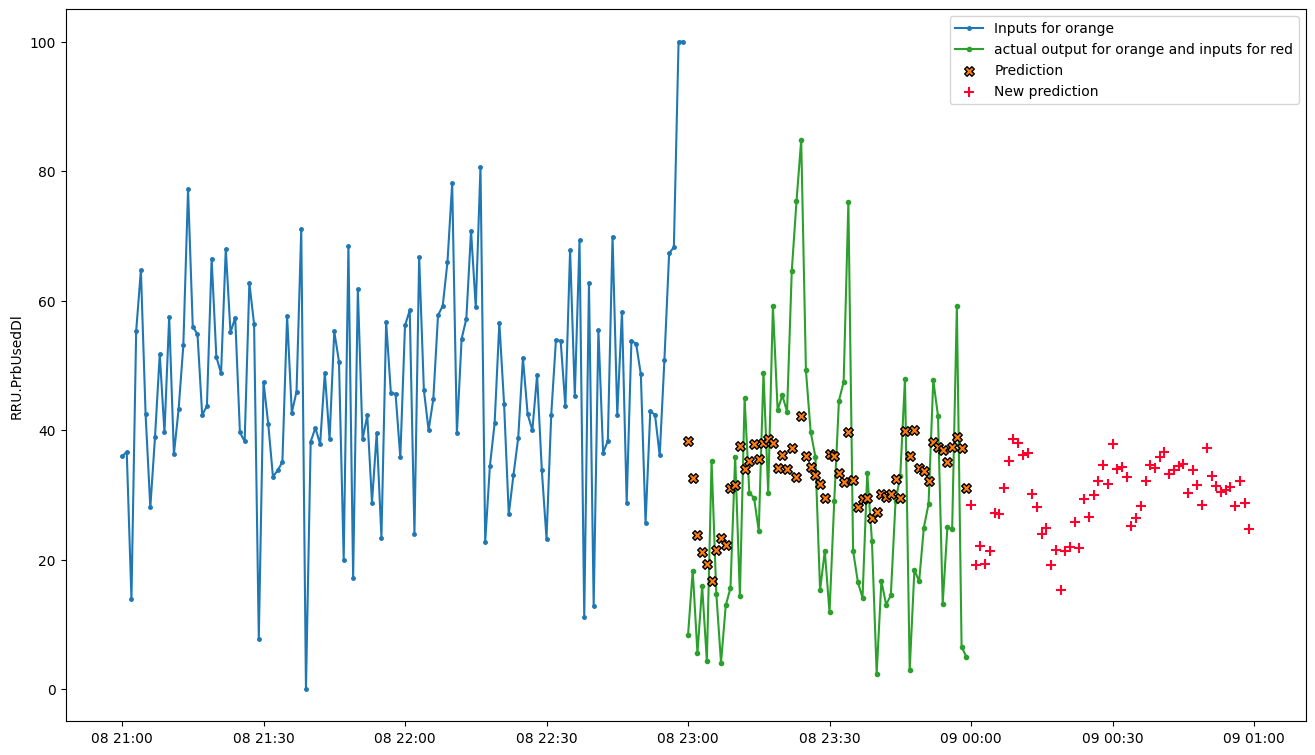


Validation (test) Plot:
1/1 [==============================] - 0s 20ms/step


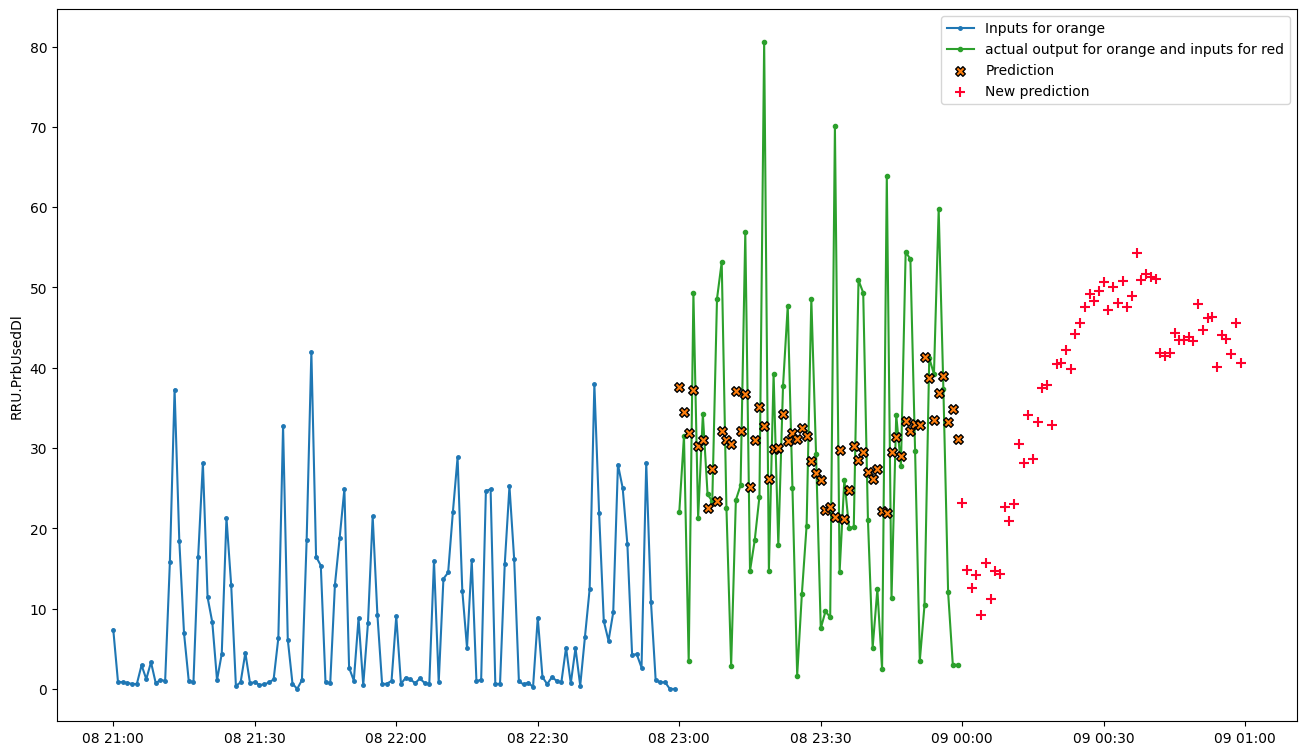

In [10]:
df_start, cell_name= import_data("D:\\KULIAH\\teep\\AI\\dataset\\08_01_2024\\CellReports.csv")
#now = datetime.datetime.now()
timestamp = "cnn0802_dua"
for index in range(0,1):
    print(index)

    train_df = df_start[df_start['Viavi.Cell.Name'] == train_name_cells[index]]
    train_df = train_df.loc[~train_df.index.duplicated()]
    train_df=train_df.drop(columns=['Viavi.Cell.Name']).astype(float).copy()

    val_df= df_start[df_start['Viavi.Cell.Name'] == test_name_cells[0]]
    val_df=val_df.loc[~val_df.index.duplicated()]
    val_df=val_df.drop(columns=['Viavi.Cell.Name']).astype(float).copy()

    name_file='4hour_%s_%s.hdf5'%(timestamp, index+1)
    name_file_before='4hour_%s_%s.hdf5'%(timestamp, index)
    print("name_file: ", name_file)
    print("name_file_before: ", name_file_before)
    print("Cell Name: ", cell_name[index])
    #display(train_df)
    running_program(train_df=train_df, val_df=val_df, index_cell=index, name_file=name_file, name_file_before=name_file_before)